In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Conversión de unidades de valores físicos

In [ ]:
    ###Valores reportados en literatura###
#Difusividad cloruro
DC_A = 6.8*1e-12   #En arcilla [m^2/s]
#Difusividad nitrato
DN_A = 1.7*1e-11 #En arcilla [m^2/s]

    ###Adaptacion a unidades de interes###
t = 60*60*24*30   #Cantidad de segundos en 30 días
#Difusividad cloruro
DC_A1 = DC_A*1e4*t   #En arcilla [cm^2/mes]
#Difusividad nitrato
DN_A1 = DN_A*1e4*t   #En arcilla [cm^2/mes]

    ###Valores estimados###
#Coeficiente de transferencia de masa en la entrada
k1_0 = 2*1e-12      #[m/s]
k1 = k1_0*100*t     #[cm/mes]
#Coeficientes de transferencia de masa en la salida
k2C_0 = 5*1e-7       #[m/s]
k2N_0 = 1.5*1e-4     #[m/s]
k2C = k2C_0*100*t    #[cm/mes]
k2N = k2N_0*100*t    #[cm/mes]

## Definicion de parámetros

In [3]:
           ##Paso computacional##
dt = 1 #Delta t [mes]
dz = 1 #Delta z [cm]

           #####Valores de parametros físicos#####
#Parametros de cloruro
DifC = DC_A1 #Coeficientes de difusividad en arcilla y tierra
#Parametros de nitrato
DifN = DN_A1 #Coeficientes de difusividad en arcilla y tierra



           #####Coeficientes de discretizacion FTCS#####
#Cloruro
# Coeficientes en arcilla
A_C = DifC*dt/(dz**2)                        #Termino que multiplica C_{i-1}
B_C = 1 - 2*DifC*dt/(dz**2)                  #Termino que multiplica C_{i}
C_C = DifC*dt/(dz**2)                        #Termino que multiplica C_{i+1}

#Nitrato
# Coeficientes en arcilla
A_N = DifN*dt/(dz**2)                        #Termino que multiplica C_{i-1} 
B_N = 1 - 2*DifN*dt/(dz**2)                  #Termino que multiplica C_{i}
C_N = DifN*dt/(dz**2)                        #Termino que multiplica C_{i+1}


           #####Coeficientes de discretizacion condicion de borde de entrada#####
#Cloruro
gammaC = dz*k1/DifC                          #Termino que multiplica C_{ext} en nodo de entrada
phiC = 1-gammaC                                 #Termino que multiplica C_{0} en nodo de entrada
#Nitrato
gammaN = dz*k1/DifN                          #Termino que multiplica C_{ext} en nodo de entrada
phiN = 1-gammaN                                 #Termino que multiplica C_{0} en nodo de entrada


           #####Coeficientes de discretizacion condicion de borde de salida#####
#Cloruro
varphiC = -2*dz*k2C/DifC               
#Nitrato
varphiN = -2*dz*k2C/DifN             

####################################### 
#####Almacenamiento de coeficientes#### 
#######################################    
Clo = [A_C,B_C,C_C,phiC,varphiC]
Nit = [A_N,B_N,C_N,phiN,varphiN]

## Definición de grilla computacional

In [143]:
#ESPACIO#
N = 61
Grilla_z = np.linspace(0,60,61) # Un total de 361 nodos por incluir el punto z=0
#TIEMPOS DE INTERES#
T = [12,12*2,12*3,12*4,12*5,12*6]

## Definicion de matriz de coeficientes

In [144]:
def MATRIX(Coef):
  # "Coef" corresponde a la matriz de coeficientes a utilizar en la discrestización para un compuesto particular
  A, B, C, phi, vphi = Coef[0],Coef[1],Coef[2],Coef[3],Coef[4]  #Coeficientes asociados al transporte en arcilla

  #Esqueleto matricial inicial
  M = np.zeros([N,N])

  #Incorporacion de coeficientes
  for i in range(0,N):
    
    #Condicion de borde superior: Flux de entrada es proporcional a diferencia de concentraciones en geomembrana
    if i == 0:
      M[i][i] = A*phi + B
      M[i][i+1] = C   

    #Seccion representativa de la capa de arcilla
    elif i < 60:
      M[i][i-1] = A  
      M[i][i] = B     
      M[i][i+1] = C  

    #Condicion de borde inferior:  Flux de salida es proporcional a diferencia de concentraciones tierra-acuifero
    elif i == 60:
      M[i][i-1] = A + C
      M[i][i] = B + vphi*C   

  return M

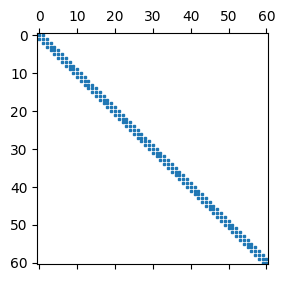

In [145]:
#Definicion de matrices para cada uno de los contaminantes
#Matriz cloruro
A1 = MATRIX(Clo)
#Matriz nitrato
A2 = MATRIX(Nit)

#Visualización
fig,ax=plt.subplots(1,1,figsize=[3,3])
ax.spy(A1,markersize=2)
plt.show()

Vector no lineal

In [146]:
#Funcion no lineal de la concentracion de entrada

def bC(tiempo):
    v = np.zeros(61)
    decC = -2*1e-9
    v[0] = 2500*np.exp(decC*t*tiempo)
    return v

def bN(tiempo):
    v = np.zeros(61)
    decN = -2*1e-8
    v[0] = 50*np.exp(decN*t*tiempo)
    return v

## Estimación numérica del perfil de concentraciones

Cloruro

In [147]:
#Concentracion inicial de cloruro en t=0
C0_C = np.zeros(N)

## Evolucion  ##

#Contador de tiempo [meses]
tC0 = 0
#Vector de concentraciones que se acutaliza
C_oldC = np.copy(C0_C)
#Almacenamiento de perfiles de concentracion
C = []
#Iteraciones
while tC0 < T[-1] :

    C_newC = A1@C_oldC + (A_C*gammaC)*bC(tC0) 
    C_oldC = np.copy(C_newC)
    tC0+=dt
    #Almacenamiento de tiempo de interés
    if tC0 in T:
        C.append(C_oldC)

Nitrato

In [148]:
#Concentracion inicial de nitrato en t=0
C0_N = np.zeros(N)

## Evolucion  ##

#Contador de tiempo [meses]
tN0 = 0
#Vector de concentraciones que se acutaliza
C_oldN = np.copy(C0_N)
#Almacenamiento de perfiles de concentracion
Ni = []
#Iteraciones
while tN0 < T[-1] :

    C_newN = A2@C_oldN + (A_N*gammaN)*bN(tN0) 
    C_oldN = np.copy(C_newN)
    tN0+=dt
    #Almacenamiento de tiempo de interés
    if tN0 in T:
        Ni.append(C_oldN)

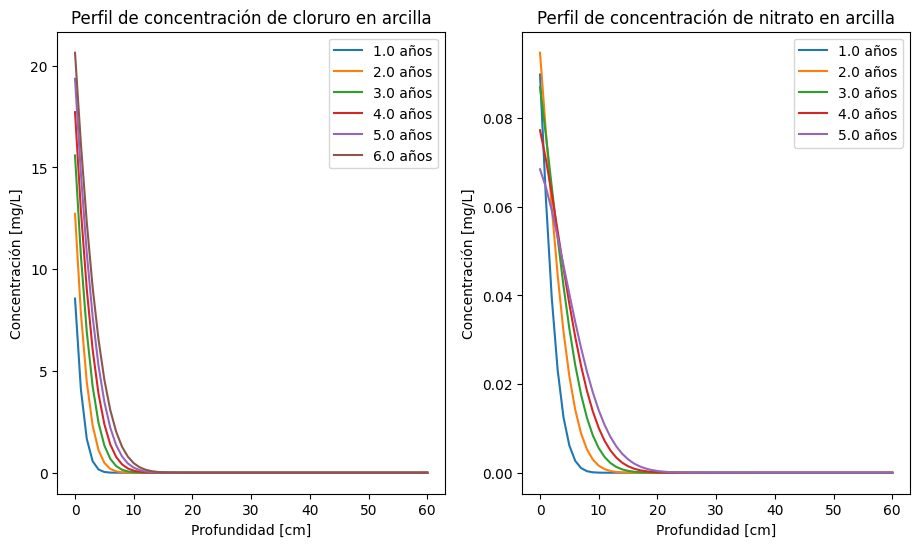

In [149]:
fig, ax = plt.subplots(1,2,figsize =[11,6])

#GRAFICO CLORURO
for j in range(0,len(C)):
    ax[0].plot(Grilla_z,C[j],label=f"{T[j]/12} años")
ax[0].set_xlabel("Profundidad [cm]")
ax[0].set_ylabel(r"Concentración [mg/L]")
ax[0].set_title("Perfil de concentración de cloruro en arcilla")
ax[0].legend()

#GRAFICO NITRATO
for j in range(0,len(Ni)-1):
    ax[1].plot(Grilla_z,Ni[j],label=f"{T[j]/12} años")
ax[1].set_xlabel("Profundidad [cm]")
ax[1].set_ylabel(r"Concentración [mg/L]")
ax[1].set_title("Perfil de concentración de nitrato en arcilla")
ax[1].legend()
plt.show()

### Aumento de concentración promedio

In [154]:
#Concentraciones en un rango menor a 10 cm

V1 = C[0][0:10]
V2 = C[1][0:10]
V3 = C[2][0:10]
V4 = C[3][0:10]
V5 = C[4][0:10]
V6 = C[5][0:10]

DeltaC = [np.mean(V2-V1), np.mean(V3-V2), np.mean(V4-V3),np.mean(V5-V4),np.mean(V6-V5)]
print(f"En promedio se aumenta {np.mean(DeltaC):.3f} mg/L de cloruro por año")

#Concentraciones en un rango menor a 10 cm

V12 = Ni[0][0:10]
V22 = Ni[1][0:10]
V32 = Ni[2][0:10]
V42 = Ni[3][0:10]
V52 = Ni[4][0:10]


DeltaN = [np.mean(V22-V12), np.mean(V32-V22), np.mean(V42-V32),np.mean(V52-V42)]
print(f"En promedio se aumenta {np.mean(DeltaN):.3f} mg/L de nitrato por año")

En promedio se aumenta 1.228 mg/L de cloruro por año
En promedio se aumenta 0.005 mg/L de nitrato por año
